In [1]:
import gdown
import os
import random
import re

import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()
from rdkit import Chem

# to display molecules
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True


# disable RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

In [2]:
# check if you have a notebook with a GPU
import torch
torch.cuda.is_available()
# If False, Go to Menu > Runtime > Change runtime. Hardware accelerator -> GPU

True

In [4]:
def download_data():
    # links from https://github.com/coleygroup/Graph2SMILES/blob/main/scripts/download_raw_data.py
    USPTO_480k_links= [
            ("https://drive.google.com/uc?id=1RysNBvB2rsMP0Ap9XXi02XiiZkEXCrA8", "src-train.txt"),
            ("https://drive.google.com/uc?id=1CxxcVqtmOmHE2nhmqPFA6bilavzpcIlb", "tgt-train.txt"),
            ("https://drive.google.com/uc?id=1FFN1nz2yB4VwrpWaBuiBDzFzdX3ONBsy", "src-val.txt"),
            ("https://drive.google.com/uc?id=1pYCjWkYvgp1ZQ78EKQBArOvt_2P1KnmI", "tgt-val.txt"),
            ("https://drive.google.com/uc?id=10t6pHj9yR8Tp3kDvG0KMHl7Bt_TUbQ8W", "src-test.txt"),
            ("https://drive.google.com/uc?id=1FeGuiGuz0chVBRgePMu0pGJA4FVReA-b", "tgt-test.txt")
        ]
    data_path = 'USPTO_480k'
    os.makedirs(data_path, exist_ok=True)
    for url, name in USPTO_480k_links:
        target_path = os.path.join(data_path, name)
        if not os.path.exists(target_path):
            gdown.download(url, target_path, quiet=False)
        else:
            print(f"{target_path} already exists")

def canonicalize_smiles(smiles, verbose=False): # will raise an Exception if invalid SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        if verbose:
            print(f'{smiles} is invalid.')
        return ''

In [6]:
download_data()

Downloading...
From: https://drive.google.com/uc?id=1RysNBvB2rsMP0Ap9XXi02XiiZkEXCrA8
To: /home/WUR/g0012069/metabolic-pathways/notebooks/USPTO_480k/src-train.txt
100%|██████████| 57.4M/57.4M [00:03<00:00, 14.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CxxcVqtmOmHE2nhmqPFA6bilavzpcIlb
To: /home/WUR/g0012069/metabolic-pathways/notebooks/USPTO_480k/tgt-train.txt
100%|██████████| 33.8M/33.8M [00:00<00:00, 51.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FFN1nz2yB4VwrpWaBuiBDzFzdX3ONBsy
To: /home/WUR/g0012069/metabolic-pathways/notebooks/USPTO_480k/src-val.txt
100%|██████████| 4.21M/4.21M [00:00<00:00, 43.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pYCjWkYvgp1ZQ78EKQBArOvt_2P1KnmI
To: /home/WUR/g0012069/metabolic-pathways/notebooks/USPTO_480k/tgt-val.txt
100%|██████████| 2.47M/2.47M [00:00<00:00, 58.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=10t6pHj9yR8Tp3kDvG0KMHl7Bt_TUbQ8W
To: /home/WUR/g0012069/metabolic-pathways/notebooks/US

# Load the data

In [7]:
line_count = !cat USPTO_480k/src-train.txt | wc -l
total = int(line_count[0])
with open('USPTO_480k/src-train.txt', 'r') as f:
    precursors_train = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
with open('USPTO_480k/tgt-train.txt', 'r') as f:
    products_train = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

line_count = !cat USPTO_480k/src-val.txt | wc -l
total = int(line_count[0])
with open('USPTO_480k/src-val.txt', 'r') as f:
    precursors_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
with open('USPTO_480k/tgt-val.txt', 'r') as f:
    products_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

line_count = !cat USPTO_480k/src-test.txt | wc -l
total = int(line_count[0])
with open('USPTO_480k/src-test.txt', 'r') as f:
    precursors_test = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
with open('USPTO_480k/tgt-test.txt', 'r') as f:
    products_test = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

  0%|          | 0/409034 [00:00<?, ?it/s]

  0%|          | 0/409034 [00:00<?, ?it/s]

  0%|          | 0/29999 [00:00<?, ?it/s]

  0%|          | 0/29999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

In [8]:
train_df = pd.DataFrame({'precursors': precursors_train, 'products': products_train})
print(f"The training set contains {train_df.shape[0]} reactions.")

val_df = pd.DataFrame({'precursors': precursors_val, 'products': products_val})
print(f"The validation set contains {val_df.shape[0]} reactions.")

test_df = pd.DataFrame({'precursors': precursors_test, 'products': products_test})
print(f"The test set contains {test_df.shape[0]} reactions.")

train_df.to_csv('USPTO_480k/train_df.csv')
val_df.to_csv('USPTO_480k/val_df.csv')
test_df.to_csv('USPTO_480k/test_df.csv')

The training set contains 409035 reactions.
The validation set contains 30000 reactions.
The test set contains 40000 reactions.


# Load saved datasets

In [9]:
train_df = pd.read_csv('USPTO_480k/train_df.csv',index_col=0)
val_df = pd.read_csv('USPTO_480k/val_df.csv',index_col=0)
test_df = pd.read_csv('USPTO_480k/test_d.csv',index_col=0)

# Sanity chech - Canoncalization

There is no standard for the canonicalization of SMILES. We might find SMILES that differ... A potential reason for this is that the canonicalization has changed with a newer RDKit version. So, always state the RDKit version that you are working with.

In [10]:
line_count = !cat USPTO_480k/src-val.txt | wc -l
total = int(line_count[0])+1
with open('USPTO_480k/src-val.txt', 'r') as f:
    can_precursors_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

for smiles, can_smiles in zip(precursors_val, can_precursors_val):
    try:
        assert smiles == can_smiles
    except AssertionError:
        print(smiles)
        print(can_smiles)
    break

  0%|          | 0/30000 [00:00<?, ?it/s]

NameError: name 'precursors_val' is not defined

# Tokenization

To be able to train a language model, we need to split the strings into tokens.

We take the regex pattern introduced in the Molecular Transformer.

In [11]:
SMI_REGEX_PATTERN =  r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

def smiles_tokenizer(smiles):
    smiles_regex = re.compile(SMI_REGEX_PATTERN)
    tokens = [token for token in smiles_regex.findall(smiles)]
    return ' '.join(tokens)

print('Tokenizing training set')
train_df['tokenized_precursors'] = train_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
train_df['tokenized_products'] = train_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing validation set')
val_df['tokenized_precursors'] = val_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
val_df['tokenized_products'] = val_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing test set')
test_df['tokenized_precursors'] = test_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
test_df['tokenized_products'] = test_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))

Tokenizing training set


  0%|          | 0/409035 [00:00<?, ?it/s]

  0%|          | 0/409035 [00:00<?, ?it/s]

Tokenizing validation set


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Tokenizing test set


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

# Save the preprocessed data set

Don't forget to shuffle the training set before saving it. At least earlier versions of OpenNMT-py would not shuffle it during preprocessing.

In [12]:
shuffled_train_df = train_df.sample(frac=1., random_state=42)

data_path = 'USPTO_480k_preprocessed'

os.makedirs(data_path, exist_ok=True)
with open(os.path.join(data_path, 'precursors-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_train_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_train_df.tokenized_products.values))

with open(os.path.join(data_path, 'precursors-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_products.values))
    
with open(os.path.join(data_path, 'precursors-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_products.values))

In [13]:
train_df = shuffled_train_df.copy()
train_df.head(3)

,precursors,products,tokenized_precursors,tokenized_products
342607,CC(O)OCCC(c1ccccc1)(c1ccccc1)c1ccccc1.Oc1ccc(I...,CC(O)OCCOc1ccc(I)cc1,C C ( O ) O C C C ( c 1 c c c c c 1 ) ( c 1 c ...,C C ( O ) O C C O c 1 c c c ( I ) c c 1
130338,CCN(CC)CC.CN1CCC(O)N(c2nnc(C3CC3)s2)C1=O.O=C(C...,CN1CCC(OC(=O)c2ccccc2)N(c2nnc(C3CC3)s2)C1=O,C C N ( C C ) C C . C N 1 C C C ( O ) N ( c 2 ...,C N 1 C C C ( O C ( = O ) c 2 c c c c c 2 ) N ...
95600,C1CCOC1.CC(C)(C)c1ccc(OCC(=O)O)cn1.CS(=O)(=O)N...,CC(C)(C)c1ccc(OCC(=O)NCc2ccc(NS(C)(=O)=O)c(F)c...,C 1 C C O C 1 . C C ( C ) ( C ) c 1 c c c ( O ...,C C ( C ) ( C ) c 1 c c c ( O C C ( = O ) N C ...


# Building the vocab

In [27]:
# !pip install pip install OpenNMT-py==2.2.0

The training can take more than 24 hours on a single GPU. Hence, we will download the trained model.

In [39]:
trained_model_url = 'https://drive.google.com/uc?id=1ywJCJHunoPTB5wr6KdZ8aLv7tMFMBHNy'
model_folder = 'models'
model_name = 'USPTO480k_model_step_400000.pt'

os.makedirs(model_folder, exist_ok=True)
target_path = os.path.join(model_folder, model_name)
if not os.path.exists(target_path):
    gdown.download(trained_model_url, target_path, quiet=False)
else:
    print(f"{target_path} already exists")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1ywJCJHunoPTB5wr6KdZ8aLv7tMFMBHNy
From (redirected): https://drive.google.com/uc?id=1ywJCJHunoPTB5wr6KdZ8aLv7tMFMBHNy&confirm=t&uuid=ddd76baa-68c2-433e-a688-ca94a1aaf1cb
To: /home/WUR/g0012069/metabolic-pathways/notebooks/models/USPTO480k_model_step_400000.pt
100%|██████████| 95.2M/95.2M [00:00<00:00, 115MB/s] 


In [43]:
import torch 

model_path = f'{model_folder}/{model_name}'
# Load the model
model = torch.load(model_path)

In [45]:
val_df.iloc[0]

precursors                     CC(C)=O.COc1ccc(S(=O)(=O)Cl)cc1.[I-].[Na+]
products                                            COc1ccc(S(=O)[O-])cc1
tokenized_precursors    C C ( C ) = O . C O c 1 c c c ( S ( = O ) ( = ...
tokenized_products                 C O c 1 c c c ( S ( = O ) [O-] ) c c 1
Name: 0, dtype: object

In [83]:
!onmt_translate -model models/USPTO480k_model_step_400000.pt -gpu 0 \
    --src precursors-val_first_line.txt \
    --tgt products-val_first_line.txt \
    --output models/USPTO480k_model_step_400000_val_predictions.txt \
    --n_best 5 --beam_size 12 --max_length 30 --batch_size 1

[2023-06-26 12:29:15,654 INFO] Translating shard 0.
[2023-06-26 12:29:16,434 INFO] PRED AVG SCORE: -0.0769, PRED PPL: 1.0800
[2023-06-26 12:29:16,435 INFO] GOLD AVG SCORE: -2.9600, GOLD PPL: 19.2988


# Visualize reactions

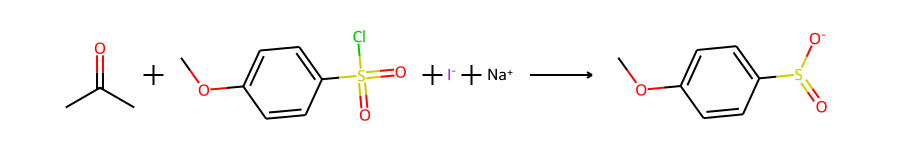

In [70]:
from rdkit.Chem import AllChem, Draw

def visualize_chemical_reaction(reaction_smarts: str):
    # Create a RDKit reaction object from reaction SMARTS string
    reaction = AllChem.ReactionFromSmarts(reaction_smarts, useSmiles=True)
    # Display images
    display(reaction)
    
rxn_example = f'{val_df.iloc[0,0]}>>{val_df.iloc[0,1]}'

visualize_chemical_reaction(rxn_example)

In [65]:
kegg_df = pd.read_csv('../data/compounds_final.csv', index_col=0)
kegg_df = kegg_df[['Entry','Names', 'SMILES']]
kegg_df.head()

,Entry,Names,SMILES
0,C00001,"[""H2O"", ""Water""]",O
1,C00002,"[""ATP"", ""Adenosine 5'-triphosphate""]",Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...
2,C00003,"[""NAD+"", ""NAD"", ""Nicotinamide adenine dinucleo...",NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...
3,C00004,"[""NADH"", ""DPNH"", ""Reduced nicotinamide adenine...",NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...
4,C00005,"[""NADPH"", ""TPNH"", ""Reduced nicotinamide adenin...",NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...


In [84]:
for entry in ['C00047','C04076','C00450','C00408']:
    print(smiles_tokenizer(kegg_df[kegg_df['Entry']==entry]['SMILES'].values[0]), kegg_df[kegg_df['Entry']==entry]['Names'].values[0])

N C C C C [C@H] ( N ) C ( = O ) O ["L-Lysine", "Lysine acid", "2,6-Diaminohexanoic acid"]
N [C@@H] ( C C C C = O ) C ( = O ) O ["L-2-Aminoadipate 6-semialdehyde", "2-Aminoadipate 6-semialdehyde", "L-Allysine", "Allysine", "(S)-2-Amino-6-oxohexanoate"]
O = C ( O ) [C@@H] 1 C C C C = N 1 ["(S)-2,3,4,5-Tetrahydropyridine-2-carboxylate", "Delta1-Piperideine-6-L-carboxylate"]
O = C ( O ) [C@@H] 1 C C C C N 1 ["L-Pipecolate", "Pipecolinic acid", "Pipecolic acid", "2-Piperidinecarboxylic acid", "(S)-Piperidine-2-carboxylic acid"]
